### Introduction
This kernel used "pre-trained" model to Classifiy "dog" and "cat" images.

Note: 
* Include a curve to display loss and accuracy during training.
* Write in detail what are pre-trained models.
* Follow basic script from previous kernel https://www.kaggle.com/chandraroy/dogs-vs-cats-redux-kernels-edition-v1

## V1.
* Accuracy:0.25

## V2.
* Add a droput layer in the dense part of VGG16
* Validation: shuffle=False
* Accuracy: 0.28635

### Using a pre-trained covnet
A pretrained network is saved network that was previously trained on a large dataset, typically on a large-scale image-classification task [1]. Following are some popular pre-trained model architectures:
1. VGG
2. ResNet
3. Inception
4. Inception-ResNet, and 
5. Xception.

The spatial hierarchy of features learned by these pre-trained network work effectively as generic model for many difficult computer visions problems, eventhough, these new problems may involve completely different images and classes than the original image. This kernel uses VGG16 architecture trained on ImageNet dataset. VGG16 was developed by Karen Simonyan and Andrew Zisserman in the year 2014 [2].

### VGG16 
VGG16 was trained on ImageNet dataset that comprises of over 1000 classes with roughly 1.2 million training images. The ImageNet images have variable resolution; therefore all the images were down-sampled to a ficed resolution of 25 x 256. The architecture of VGG16 is shown below.
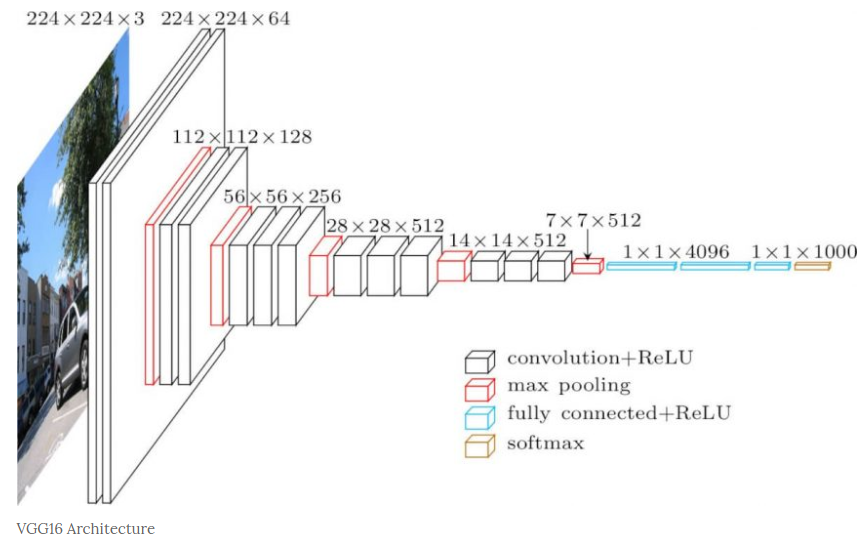
The input to cov1 layer is of fixed size 224 x 224 RGB image. Additionally, it uses filter of size 3 x 3 ( which is the smallest size to capture the notion of left/right, up/down, and center). Further, it uses convolution srtide of 1 pixel; and max-pooling is performed over a 2x2 pixel window.  



1. Chollet, Francois;"Deep Learning with Python". pp (384).2017
2. Simonyan, Karen, and Andrew Zisserman. "Very deep convolutional networks for large-scale image recognition." arXiv preprint arXiv:1409.1556 (2014).

There are two ways to use a pretrained network:
1. Feature extraction, and 
2. Fine-tuning.

### Feature extraction
Feature extraction consists of using the representation learned by a previous nework to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

_Convnets_ used for image classification comprise of two parts: they start with a series of pooling and convolution layers, and they end with a densely connected classifier. The first part is called the _convolutional base_ of the model. In the case of convnets, feature extraction consists of taking the convolutional base of a previously trained network, running the new data through it, and training a new classifier on top of the output. 

##### Why reuse only the convolutional base? Could you reuse the densely connected classifier as well? 
In general one should avoid using the densely connected classifier. The reason is that the representations learned by the convolutional base are likely to be more generic and therefore more reusable: the feature maps of a convnet are presence maps of generic concepts over a picture,which is lekly to be useful regardless of the computer vision problem at hand. But the representations learned by the classifier will necessarily be specific to the set of classes on which the model was trained- they will only contain information about the presence probability of those classes in the entire pricture. Additionally, representations found in densely conneceted layres no longer contrain any information about where objects are located in the input image: these layers get rid of the notion of space, whereas the object location is till described by the convolitional feature map.

Note that the level of generality ( and therefore reusability) of the representations extracted by specific convolution layers depends on the depth of the layer in the model. Layers that come earlier in the model extract local, highly generic feature maps ( such as visual edges, colors, and textures), whereas layrs that are higher up extract omfe-abstract concepts ( such as "cat ear" or "dog ear"). So if your new dataset differs a lot from the dataset on which the original model was trained, you may be better off using only the first few layers of the model to do feature extraction, rather than using the entire convolution base.'

In this case, becasue the imageNet class set contains mulitple doga nd cat classes, it's likely to be veneficial to reuse the information contained in the denely connected layers of the original model. But we will choose not to, in order to cover the more general case shere the class set of the new problem does not overlap the class set of the original model. Let's put his in practice by using the convoltional base of hte VGG16 network, trained on ImageNet, to extract interseting features from cat and dog images, and then train a dog versus cat classifier on top of these features.

The VGG16 modek, among others, comes prepackaged with Keras. You can import it  from the _keras.applications_ module. Below is hte list of image-classification models that are available as a part of Keras.applications. 
* Xception
* Inception V3
* ReseNet50
* VGG16
* VGG19
* MobileNet

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))
print(os.listdir("../input/dogs-vs-cats-redux-kernels-edition/"))
# Any results you write to the current directory are saved as output.

['train', 'sample_submission.csv', 'test']


#### Initialization

In [2]:
original_dataset_dir = "../input/dogs-vs-cats-redux-kernels-edition/"
base_dir = "../input/dogs-vs-cats-redux-kernels-edition/cats_and_dogs_small/"

TRAIN_DIR = '../input/dogs-vs-cats-redux-kernels-edition/train/'
TEST_DIR = '../input/dogs-vs-cats-redux-kernels-edition/test/'

ROWS = 150
COLS = 150
CHANNELS = 3

train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)] # use this for full dataset
train_dogs =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
train_cats =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat' in i]

test_images =  [TEST_DIR+i for i in os.listdir(TEST_DIR)]

#### Training and test data prepration
Here, because all the training images are in the same folder _train_ and all the test images are in the same folder _test_. Training images have file names such as __cat.10047.jpg__, __dog_101.jpg__. We are going to make a train dataframe with column 'id' and 'label', where ids will be numric part of the filenames and labels will be extracted from filenames containing dog or cat. 

In [3]:
#list of labels for all the dog image.
df_train_dog = pd.DataFrame()
df_train_dog['id'] = train_dogs
df_train_dog['label']= 1
##Extract filename from the full-path.
id_temp=[]
for i in df_train_dog.id:
    id_temp.append(i.split('/')[-1])
df_train_dog['id']= id_temp    
df_train_dog.head()

,id,label
0,dog.11754.jpg,1
1,dog.11723.jpg,1
2,dog.4602.jpg,1
3,dog.6121.jpg,1
4,dog.6041.jpg,1


In [4]:
#list of labels for all the cat image.
df_train_cat = pd.DataFrame()
df_train_cat['id']= train_cats
df_train_cat['label']= 0
## Extract filename from the full-path
i_temp = []
for i in df_train_cat.id:
    i_temp.append(i.split("/")[-1])

df_train_cat['id']= i_temp
df_train_cat.head()

,id,label
0,cat.8572.jpg,0
1,cat.3314.jpg,0
2,cat.6609.jpg,0
3,cat.83.jpg,0
4,cat.9523.jpg,0


In [5]:
#Merge both cat and dog dataframe to make a df_train_all dataframe; this dataframe will be used to read images.
df_train_all = pd.concat([df_train_dog,df_train_cat], axis=0)
df_train_all = df_train_all.sample(frac=1).reset_index(drop=True)

In [6]:
#Convert 'label' column to 'str' as it will be used by ImageGenerator()
df_train_all['label'] = df_train_all['label'].astype(str)
df_train_all.head()

,id,label
0,dog.937.jpg,1
1,dog.5262.jpg,1
2,dog.5275.jpg,1
3,cat.6635.jpg,0
4,dog.6568.jpg,1


In [7]:
#shape of training data
df_train_all.shape

(25000, 2)

In [8]:
# prepareing the test data
df_test_all= pd.DataFrame()
df_test_all['id']=test_images
i_temp = []
for i in df_test_all.id:
    i_temp.append(i.split("/")[-1])

df_test_all['id']= i_temp
df_test_all.tail()

,id
12496,848.jpg
12497,8567.jpg
12498,3076.jpg
12499,2122.jpg
12500,2865.jpg


In [9]:
## Check if any file name 'test': for this dataset, it has been observed that 'folder' name is being added. 
#Get its index and drop it.
i = df_test_all[(df_test_all.id == 'test')].index
df_test_all = df_test_all.drop(i)
print(i)

Int64Index([9255], dtype='int64')


In [10]:
df_test_all = df_test_all.reset_index(drop=True)

In [11]:
#shape of training data
df_test_all.shape

(12500, 1)

### Loading Pre-trained VGG16 model

We pass three arguments to the VGG16() constructor namely weights, include_top, and input_shape.
* _weights_: specifies the weight checkpoint from which to include the model, here it is 'imagenet'.
* _inlcude-top_: It refers to including or not including the densely connected classifier on top of the network. By default, the densely connected classifier corresponds to the 1000 classes from the imageNet. Because our intention is to use our own densely connected classifier, we don't need to inlcude it.
* _input-shape_: It is the shape of the image tensor that will feed the network. It is optional argument, if you don't pass it the network will be able to process inputs of any_size.

In [12]:
from keras.applications import VGG16

conv_base = VGG16(weights= 'imagenet',
                 include_top=False,
                 input_shape=(150, 150,3))

Using TensorFlow backend.


58892288/58889256 [==============================] - 3s 0us/step


In [13]:
conv_base.trainable = False

In [14]:
from keras import models
from keras import layers
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
#model.add(layers.Dense(128, activation='relu'))
#model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))


In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


#### The final feature map has shape of 4 x 4 x 512. We need to tick a densely connected classifier on top of it.

#### Two ways to proceed
At this point, there are two ways to proceed:
* __APPROCH-1__: Running the convolutional base over your dataset, recording its output ot a Numpy array on disk, and then using this data as input to a standalone, densely connected classifier built for these new classes. This solution is fast and cheap to run, because it only requires running the convolutional base once for every input image, and the convolutional base is by far the most expensive part of the pipeline. But for the same reason, this technique doesn't allow you to use data augmentation. 
## Note: This kernel implements 2nd approch only. 
* __APPROCH-2__:Extending the model you have (conv_base) by adding 'Dense' layers on top, and running the whole thing end to end on the new input data. This will allow us to use data augmentation, because every input image goes through the onvolutional base every time it's seen by the model. But for the same reason, this technique is far moare expensive than the first.

#### APPROVH-2: Fast feature extraction with data agumentation


In [16]:
from keras.preprocessing.image import ImageDataGenerator

In [17]:
#train_datagen = ImageDataGenerator(rescale=1./255, 
#                                   validation_split=0.2,
#                                   rotation_range=10,
#                                  shear_range=0.1,
#                                  zoom_range=0.1,
#                                  horizontal_flip=False)
train_datagen = ImageDataGenerator(rescale=1./255,
                                     validation_split=0.2,
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=20.,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    channel_shift_range=0.,
    #fill_mode='nearest',
    #cval=0.,
    horizontal_flip=True,
    vertical_flip=True)
#validate_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
#test_datagen= ImageDataGenerator(rescale=1./255)
batch_size=20

In [18]:
train_generator= train_datagen.flow_from_dataframe(dataframe= df_train_all,
                                                   directory=TRAIN_DIR,
                                                   x_col='id',
                                                   y_col='label',
                                                   has_ext=True,
                                                   subset='training',
                                                   target_size=(150,150),
                                                   batch_size=batch_size,
                                                   class_mode='binary',
                                                  shuffle= True)

Found 20000 validated image filenames belonging to 2 classes.


In [19]:
valid_generator= train_datagen.flow_from_dataframe(dataframe= df_train_all,
                                                   directory=TRAIN_DIR,
                                                   x_col='id',
                                                   y_col='label',
                                                   has_ext=True,
                                                   subset='validation',
                                                   target_size=(150,150),
                                                   batch_size=batch_size,
                                                   class_mode='binary',
                                                  shuffle= False)

Found 5000 validated image filenames belonging to 2 classes.


In [20]:
test_generator= test_datagen.flow_from_dataframe(dataframe= df_test_all,
                                                   directory=TEST_DIR,
                                                   x_col='id',
                                                   y_col=None,
                                                   has_ext=True,
                                                   target_size=(150,150),
                                                   batch_size=batch_size,
                                                   class_mode=None,
                                                  shuffle=False # Keep the data as same order as label.
                                                )

Found 12500 validated image filenames.


In [21]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

In [22]:
#history = model.fit_generator(train_generator,
#                              steps_per_epoch=100,
#                              epochs=30,
#                              validation_data=valid_generator,
#                              validation_steps=5 #50
#                             )

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=25
)

Epoch 1/25
1000/1000 [==============================] - 260s 260ms/step - loss: 0.5547 - acc: 0.7072 - val_loss: 0.4498 - val_acc: 0.8006
Epoch 2/25
1000/1000 [==============================] - 215s 215ms/step - loss: 0.4534 - acc: 0.7870 - val_loss: 0.4150 - val_acc: 0.8108
Epoch 3/25
1000/1000 [==============================] - 215s 215ms/step - loss: 0.4194 - acc: 0.8039 - val_loss: 0.3975 - val_acc: 0.8168
Epoch 4/25
1000/1000 [==============================] - 213s 213ms/step - loss: 0.4098 - acc: 0.8090 - val_loss: 0.3810 - val_acc: 0.8304
Epoch 5/25
1000/1000 [==============================] - 218s 218ms/step - loss: 0.4006 - acc: 0.8150 - val_loss: 0.3808 - val_acc: 0.8264
Epoch 6/25
 908/1000 [==========================>...] - ETA: 16s - loss: 0.3979 - acc: 0.8187

#### Plotting the loss and accuracy

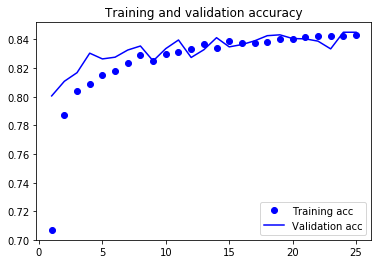

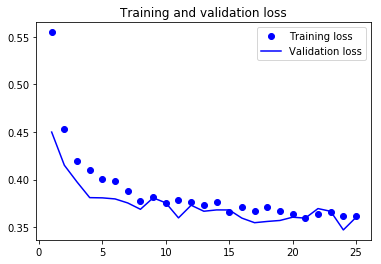

In [23]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [24]:
test_generator.reset()

In [25]:
predictions= model.predict_generator(test_generator, 
                                     steps=len(test_generator),
                                    verbose=1)

625/625 [==============================] - 70s 111ms/step


In [26]:
print(predictions)

[[1.0000000e+00]
 [8.2308054e-04]
 [9.9998850e-01]
 ...
 [9.8653865e-01]
 [1.0000000e+00]
 [5.5487597e-01]]


In [27]:
test_filenames = test_generator.filenames # This is it...

In [28]:
i_temp=[]
for i in test_filenames:
    i_temp.append(i.split('.')[0])

In [29]:
df_submit= pd.DataFrame()
df_submit['id']= i_temp #df_test_all['id']
df_submit['label']= predictions #predicted_labels #(predictions > 0.5).astype(int)
df_submit['id']= pd.to_numeric(df_submit['id'], errors='coerce') # required to remove E from long number i.e. exponential
df_submit['id']= df_submit['id'].astype(int)
df_submit.to_csv("submission_vgg16.csv", index=False)

In [30]:
df_submit.head()

,id,label
0,1174,1.000000
1,4800,0.000823
2,10003,0.999988
3,4269,0.000003
4,10554,0.932109
